In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit , transpile, Aer ,IBMQ
from qiskit.visualization import *
from qiskit.tools.jupyter import *
from qiskit.providers.ibmq import least_busy
from qiskit.providers.aer import QasmSimulator

from qiskit import Aer, QuantumCircuit
from qiskit.opflow import Z, I, StateFn
from qiskit.utils import QuantumInstance
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.algorithms.optimizers import *

from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit import *

import numpy as np

from qiskit import Aer, QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.opflow import StateFn, PauliSumOp, AerPauliExpectation, ListOp, Gradient
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.neural_networks import OpflowQNN
import qiskit.quantum_info as qi
from scipy import optimize
from qiskit.opflow.gradients import Gradient
from typing import Union

from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.exceptions import QiskitMachineLearningError
from qiskit_machine_learning.utils.loss_functions import *

from IPython.display import clear_output
from scipy.optimize import approx_fprime

In [2]:
# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [3]:
def amplitude_encoding(num_qubits,x):
    if 2**num_qubits < len(x) : return("Need More Qubits") 
    data = np.zeros(2**num_qubits)
    data[:len(x)]=x
    qc = RawFeatureVector(num_qubits,name ="Amplitude Encoding")
    qc.assign_parameters(data)
    encode = qc.to_gate()
    return encode

In [4]:
def qubit_encoding(num_qubits,x):
    qc = QuantumCircuit(num_qubits,name = "Qubit Encoding")
    for i in range(num_qubits):
        qc.ry(x[i], [i], label='qubit_encoding X'+str(i))
    encode = qc.to_gate()
    return encode

In [5]:
def swap(x_1,x_2,kernel,n_kernel):
    qc = QuantumCircuit(n_kernel*2+1,1)
    qc.h(n_kernel*2)

    x_1 = kernel(n_kernel,x_1)
    x_2 = kernel(n_kernel,x_2)
    qc.append(x_1,range(n_kernel))
    qc.append(x_2,range(n_kernel,(n_kernel*2)))

    for i in range(n_kernel):
        qc.cswap(n_kernel*2,i,i+n_kernel)
    qc.h(n_kernel*2)
    qc.measure(n_kernel*2,0)
    return(qc)

$\def\ket#1{\mid #1 \rangle}$
$\def\bra#1{\langle #1 \mid}$

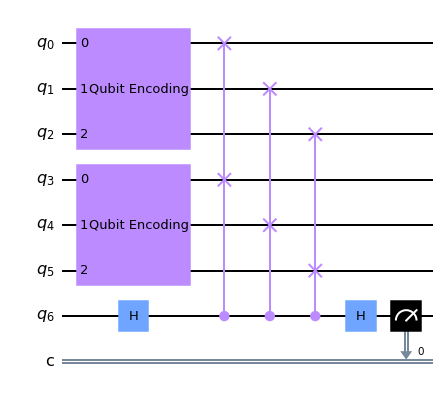

In [6]:
x1 = [1,2,3]
x1 = x1/np.linalg.norm(x1)
x2 = [1,2,9]
x2 = x2/np.linalg.norm(x2)

qc = swap(x1,x2,qubit_encoding,3)
qc.draw("mpl")

Output : 

$\ket{\psi_1} = \frac{1}{\sqrt{2}}(\ket 0 + \ket 1)\ket{\psi_\alpha \psi_\beta}$

$\ket{\psi_2} = Fredkin(\ket{\psi_1}) \\\  \ \quad = \ket{0\psi_\alpha\psi_\beta}+\ket{1\psi_\beta\psi_\alpha}$

$\ket{\psi_3} = \ket{0}(\ket{\psi_\alpha \psi_\beta}+\ket{\psi_\beta \psi_\alpha}) + \ket{1}(\ket{\psi_\alpha \psi_\beta}-\ket{\psi_{\beta}\psi_{\alpha}} $

Measure: 

$p(0) = \frac{1}{2} + \frac{1}{2}\mid\langle \psi_\alpha, \psi_ \beta \rangle\mid^2$

$\mid\langle \psi_\alpha, \psi_ \beta \rangle\mid = \sqrt{2Pr(0)-1}$

$k(x,x') = \{\bra{\phi(x)}\ket{\phi(x')}\}$

$\phi(x) \propto exp(-\frac{1}{2 \sigma^2} \parallel x- x_i \parallel^2)$

In [7]:
def hadamard(x_1,x_2,kernel,n_kernel):
    qc = QuantumCircuit(n_kernel+1,1)
    qc.h(n_kernel)

    x_1 = kernel(n_kernel,x_1).control(1)
    x_2 = kernel(n_kernel,x_2).control(1)
    qc.append(x_1,[n_kernel,*[i for i in range(n_kernel)]])
    qc.x(n_kernel)
    qc.append(x_2,[n_kernel,*[i for i in range(n_kernel)]])
    qc.h(n_kernel)
    qc.measure(n_kernel,0)
    return(qc)

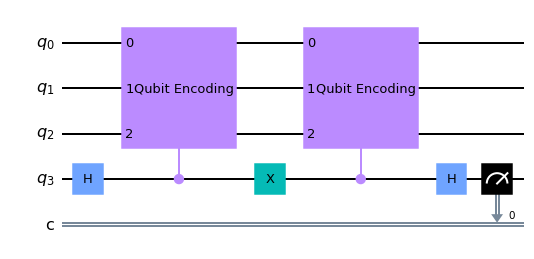

In [8]:
qc = hadamard(x1,x2,qubit_encoding,3)
qc.draw("mpl")



1. $\ \ket{\psi_1} = \frac{1}{\sqrt 2}( \ket 0 + \ket 1) \ket 0 \\\ \qquad  \propto \ket {00} + \ket {10}$

2. $\ \ket {\psi_2} =  cU_{\alpha} (\ket {00} + \ket {10})\\\ \qquad = \ket{00}+\ket{1 \ \psi_\alpha}$

3. $\ \ket{\psi_3} = \ket{10}+\ket{0\psi_\alpha}$

4. $\ket{\psi_4} = cU_{\beta}(\ket{10}+\ket{0\psi_\alpha}) \\\ \qquad = \ket{1 \psi_\beta} + \ket{0\psi_\alpha}$

5. $\ \ket{\psi_5} = (\ket{0} + \ket{1})\ket{\psi_\alpha} +(\ket 0 - \ket 1)\ket {\psi_\beta} \\\ \qquad \propto \frac{1}{2}\ket{0}(\ket{\psi_\alpha}+\ket{\psi_\beta})+\frac{1}{2}\ket{1} (\ket{\psi_\alpha} - \ket{\psi_\beta}) $

6. Measure :

$p(0) = \frac{1}{2}^2\mid\ket{\psi_\alpha}+\ket{\psi_\beta}\mid^2 = \frac{1}{2} + \frac{1}{2}Re\{\langle \psi_\alpha \mid \psi_{\beta} \rangle\}$

$p(1) =  \frac{1}{2}^2\mid\ket{\psi_\alpha}-\ket{\psi_\beta}\mid^2 = \frac{1}{2} - \frac{1}{2}Re\{\langle \psi_\alpha \mid \psi_{\beta} \rangle\}$

$Re\{\langle \psi_\alpha \mid \psi_{\beta} \rangle\} = 2p(0)-1$

In [9]:
def hadamard_inner(x1,x2,kernel,n_kernel,shots=10000):
    hadamard_circuit = hadamard(x1,x2,kernel,n_kernel)
    
    backend = QasmSimulator()
    qc_compiled = transpile(hadamard_circuit, backend)
    
    job = backend.run(qc_compiled, shots=shots)
    counts = job.result().get_counts ()
    
    hatpr0 = counts["0"]/shots
    quantum_inner = 2*hatpr0-1
    return(quantum_inner)

In [10]:
def swap_inner(x1,x2,kernel,n_kernel,shots=10000):
    circuit = swap(x1,x2,kernel,n_kernel)
    
    backend = QasmSimulator()
    qc_compiled = transpile(circuit, backend)
    
    job = backend.run(qc_compiled, shots=shots)
    counts = job.result().get_counts ()
    
    hatpr0 = counts["0"]/shots
    quantum_inner = np.sqrt(2*hatpr0-1)
    return(quantum_inner)

In [11]:
def classic_qubit_encoding(theta) :
    result = [1]
    for i in theta :
        result_temp = []
        for j in result :
            result_temp = [*result_temp,*[j*np.cos(i),j*np.sin(i)]]
        result = result_temp
    return(result)

In [12]:
x1 = np.array([-2,2,3])
x1 = x1/(2*np.pi)
x2 = np.array([2,2,1])
x2 = x2/(2*np.pi)

## Qubit encoding의 경우

Qubit Encoding에는 복소수가 포함되어 있지 않다. 

In [13]:
x1 = np.array([1,2,3])
x1 = x1*2
x2 = np.array([2,3,4])
x2 = x2*2

$\ket{\Psi(x_1)} = \left[ \begin{array}{c} \cos(x_{11}) \\ \sin (x_{11}) \end{array}\right] \otimes  \left[ \begin{array}{c} \cos(x_{12}) \\ \sin (x_{12}) \end{array}\right] \otimes  \left[ \begin{array}{c} \cos(x_{13}) \\ \sin (x_{13}) \end{array}\right]$

$\ket{\Psi(x_2)} = \left[ \begin{array}{c} \cos(x_{21}) \\ \sin (x_{21}) \end{array}\right] \otimes  \left[ \begin{array}{c} \cos(x_{22}) \\ \sin (x_{22}) \end{array}\right] \otimes  \left[ \begin{array}{c} \cos(x_{23}) \\ \sin (x_{23}) \end{array}\right]$


$\bra{\Psi(x_1)}\ket{\Psi(x_2)}$를 직접 구한 내적값은 아래와 같다.

In [14]:
np.inner(classic_qubit_encoding(x1),classic_qubit_encoding(x2))

-0.07206755574776526

해당 내적의 이론상의 값은 아래와 같이 $\prod \cos (x_1-x_2)$로 결정된다. 

$$\bra{\Psi(x_1)}\ket{\Psi(x_2)} = \left[ \begin{array}{c} \cos(x_{11}) \\ \sin (x_{11}) \end{array}\right]^t  \left[ \begin{array}{c} \cos(x_{21}) \\ \sin (x_{21}) \end{array}\right]  \otimes  \left[ \begin{array}{c} \cos(x_{12}) \\ \sin (x_{12}) \end{array}\right]^t  \left[ \begin{array}{c} \cos(x_{22}) \\ \sin (x_{22}) \end{array}\right] \otimes  \left[ \begin{array}{c} \cos(x_{13}) \\ \sin (x_{13}) \end{array}\right]^t  \left[ \begin{array}{c} \cos(x_{32}) \\ \sin (x_{32}) \end{array}\right]$$
             
$$= \prod \left[ \sin (x_{1i}) \sin (x_{2i}) + \cos (x_{1i}) \cos (x_{2i}) \right]$$ 

$$= \prod \cos (x_{1i} - x_{2i})$$

이 공식을 이용해 직접 구한 내적값은 아래와 같다. 

In [41]:
np.exp(np.sum(np.log(np.cos(x1-x2))))

<ipython-input-41-0297201ff799>:1: RuntimeWarning: invalid value encountered in log
  np.exp(np.sum(np.log(np.cos(x1-x2))))


nan

위에서 설계한 Hadamard Test와 Swap Test를 이용해서 추정해낸 값은 아래와 같다.  

In [42]:
hadamard_inner(x1,x2,qubit_encoding,3,shots=80000)

0.16822500000000007

In [43]:
swap_inner(x1,x2,qubit_encoding,3,shots=80000)

0.15033296378372893

## General Kernel Esitmator

Qiskit의 Pauli Rotation Operator의 주기는 $4 \pi$이다. 즉 kernel([0,0,0,..]) = kernel([$4\pi,4 \pi,4 \pi , ...$])이다.  
따라서 데이터의 Max 값을 $4\pi$로 맞춰주는 전처리 과정이 필수적이다. 

In [18]:
def kernel_A(x):
    r = 2
    n = len(x)
    num_qubits = int(((n-1)+ (r-(n-1)%r))/r)
    x = x+np.zeros(r*num_qubits-n).tolist()

    qc = QuantumCircuit(num_qubits,name = "Kernel A")
    
    for i in range(num_qubits):
        qc.rx(x[i], [i])
    for i in range(num_qubits):
        qc.rz(x[i+num_qubits], [i])
    encode = qc.to_gate()
    return [encode,num_qubits]

def kernel_B(x):
    r = 2
    n = len(x)
    num_qubits = int(((n-1)+ (r-(n-1)%r))/r)
    x = x+np.zeros(r*num_qubits-n).tolist()
    
    qc = QuantumCircuit(num_qubits,name = "Kernel B")
    
    for i in range(num_qubits):
        qc.rx(x[i], [i])
    for i in range(num_qubits):
        qc.rz(x[i+num_qubits], [i])
    for i in range(num_qubits-1):
        qc.cx([i+1],[i])
    qc.cx([0],[num_qubits-1])
    encode = qc.to_gate()
    return [encode,num_qubits]

def kernel_C(x):
    r = 3
    n = len(x)
    num_qubits = int(((n-1)+ (r-(n-1)%r))/r)
    x = x+np.zeros(r*num_qubits-n).tolist()
    
    qc = QuantumCircuit(num_qubits,name = "Kernel C")
    
    for i in range(num_qubits):
        qc.rx(x[i], [i])
    for i in range(num_qubits):
        qc.rz(x[i+num_qubits], [i])
    for i in range(num_qubits-1):
        qc.crz(x[i+2*num_qubits],[i+1],[i])
    qc.crz(x[3*num_qubits-1],[0],[num_qubits-1])
    encode = qc.to_gate()
    
    return [encode,num_qubits]

def kernel_D(x):
    r = 3
    n = len(x)
    num_qubits = int(((n-1)+ (r-(n-1)%r))/r)
    x = x+np.zeros(r*num_qubits-n).tolist()
    
    qc = QuantumCircuit(num_qubits,name = "Kernel D")
    
    for i in range(num_qubits):
        qc.rx(x[i], [i])
    for i in range(num_qubits):
        qc.rz(x[i+num_qubits], [i])
    for i in range(num_qubits-1):
        qc.crz(x[i+2*num_qubits],[i+1],[i])
    qc.crx(x[3*num_qubits-1],[0],[num_qubits-1])
    encode = qc.to_gate()
    
    return [encode,num_qubits]

def kernel_E(x):
    r = 1
    n = len(x)
    num_qubits = int(((n-1)+ (r-(n-1)%r))/r)
    x = x+np.zeros(r*num_qubits-n).tolist()
    
    qc = QuantumCircuit(num_qubits,name = "Kernel E")
    for i in range(num_qubits):
        qc.h([i])
    for i in range(num_qubits-1):
        qc.cz([i],[i+1])
    qc.cz(num_qubits-1,0)
    for i in range(num_qubits):
        qc.rz(x[i],[i])
    encode = qc.to_gate()
    return [encode,num_qubits]

def kernel_F(x):
    r = 2
    n = len(x)
    num_qubits = int(((n-1)+ (r-(n-1)%r))/r)
    x = x+np.zeros(r*num_qubits-n).tolist()
    qc = QuantumCircuit(num_qubits,name = "Kernel F")
    for i in range(num_qubits):
        qc.ry(x[i],[i])
    for i in range(num_qubits-1):
        qc.cz([i],[i+1])
    qc.cz(num_qubits-1,0)
    for i in range(num_qubits):
        qc.ry(x[i+num_qubits],[i])
    encode = qc.to_gate()
    return [encode,num_qubits]

def kernel_G(x):
    r = 2
    n = len(x)
    num_qubits = int(((n-1)+ (r-(n-1)%r))/r)
    x = x+np.zeros(r*num_qubits-n).tolist()
    
    qc = QuantumCircuit(num_qubits,name = "Kernel G")
    
    for i in range(num_qubits):
        qc.ry(x[i],[i])
    for i in range(num_qubits-1):
        qc.cx([i+1],[i])
    qc.cx(0,num_qubits-1)

    for i in range(num_qubits):
        qc.ry(x[i+num_qubits],[i])
    for i in range(num_qubits-1):
        qc.cx([i],[i+1])
    qc.cx(num_qubits-1,0)
    encode = qc.to_gate()
    return [encode,num_qubits]

def kernel_H(x):
    r = 4
    n = len(x)
    num_qubits = int(((n-1)+ (r-(n-1)%r))/r)
    x = x+np.zeros(r*num_qubits-n).tolist()
    qc = QuantumCircuit(num_qubits,name = "Kernel H")
    for i in range(num_qubits):
        qc.ry(x[i],[i])
    for i in range(num_qubits):
        qc.rz(x[num_qubits+i],[i])
    former = int((num_qubits) /2)
    later = int((num_qubits-1) /2)
    for i in range(former):
        qc.cx([2*i+1],[2*i])
    for i in range(num_qubits):
        qc.ry(x[2*num_qubits + i],[i])
    for i in range(num_qubits):
        qc.rz(x[3*num_qubits+i],[i])
    for i in range(later):
        qc.cx([2*i+2],[2*i+1])
    encode = qc.to_gate()
    return [encode,num_qubits]

def kernel_I(x):
    r = 4
    n = len(x)
    num_qubits = int(((n-1)+ (r-(n-1)%r))/r)
    x = x+np.zeros(r*num_qubits-n).tolist()
    qc = QuantumCircuit(num_qubits,name = "Kernel I")
    for i in range(num_qubits):
        qc.ry(x[i],[i])
    for i in range(num_qubits):
        qc.rz(x[num_qubits+i],[i])
    former = int((num_qubits) /2)
    later = int((num_qubits-1) /2)
    for i in range(former):
        qc.cz([2*i+1],[2*i])
    for i in range(num_qubits):
        qc.ry(x[2*num_qubits + i],[i])
    for i in range(num_qubits):
        qc.rz(x[3*num_qubits+i],[i])
    for i in range(later):
        qc.cz([2*i+2],[2*i+1])
    encode = qc.to_gate()
    return [encode,num_qubits]

def kernel_J(x):
    r = 4
    n = len(x)
    num_qubits = int(((n-1)+ (r-(n-1)%r))/r)
    x = x+np.zeros(r*num_qubits-n).tolist()
    qc = QuantumCircuit(num_qubits,name = "Kernel J")
    for i in range(num_qubits):
        qc.ry(x[i],[i])
    
    for i in range(num_qubits-1):
        qc.crz(x[num_qubits+i],[i],[i+1])
    qc.crz(x[2*num_qubits-1],num_qubits-1,0)

    for i in range(num_qubits):
        qc.ry(x[2*num_qubits + i],[i])
    for i in range(num_qubits-1):
        qc.crz(x[3*num_qubits+i],[i+1],[i])
    qc.crz(x[4*num_qubits-1],0,num_qubits-1)
    encode = qc.to_gate()
    return [encode,num_qubits]

def kernel_K(x):
    r = 4
    n = len(x)
    num_qubits = int(((n-1)+ (r-(n-1)%r))/r)
    x = x+np.zeros(r*num_qubits-n).tolist()
    qc = QuantumCircuit(num_qubits,name = "Kernel K")
    for i in range(num_qubits):
        qc.ry(x[i],[i])
    
    for i in range(num_qubits-1):
        qc.crx(x[num_qubits+i],[i],[i+1])
    qc.crx(x[2*num_qubits-1],num_qubits-1,0)
    for i in range(num_qubits):
        qc.ry(x[2*num_qubits + i],[i])
    for i in range(num_qubits-1):
        qc.crx(x[3*num_qubits+i],[i+1],[i])
    qc.crx(x[4*num_qubits-1],0,num_qubits-1)
    encode = qc.to_gate()
    return [encode,num_qubits]

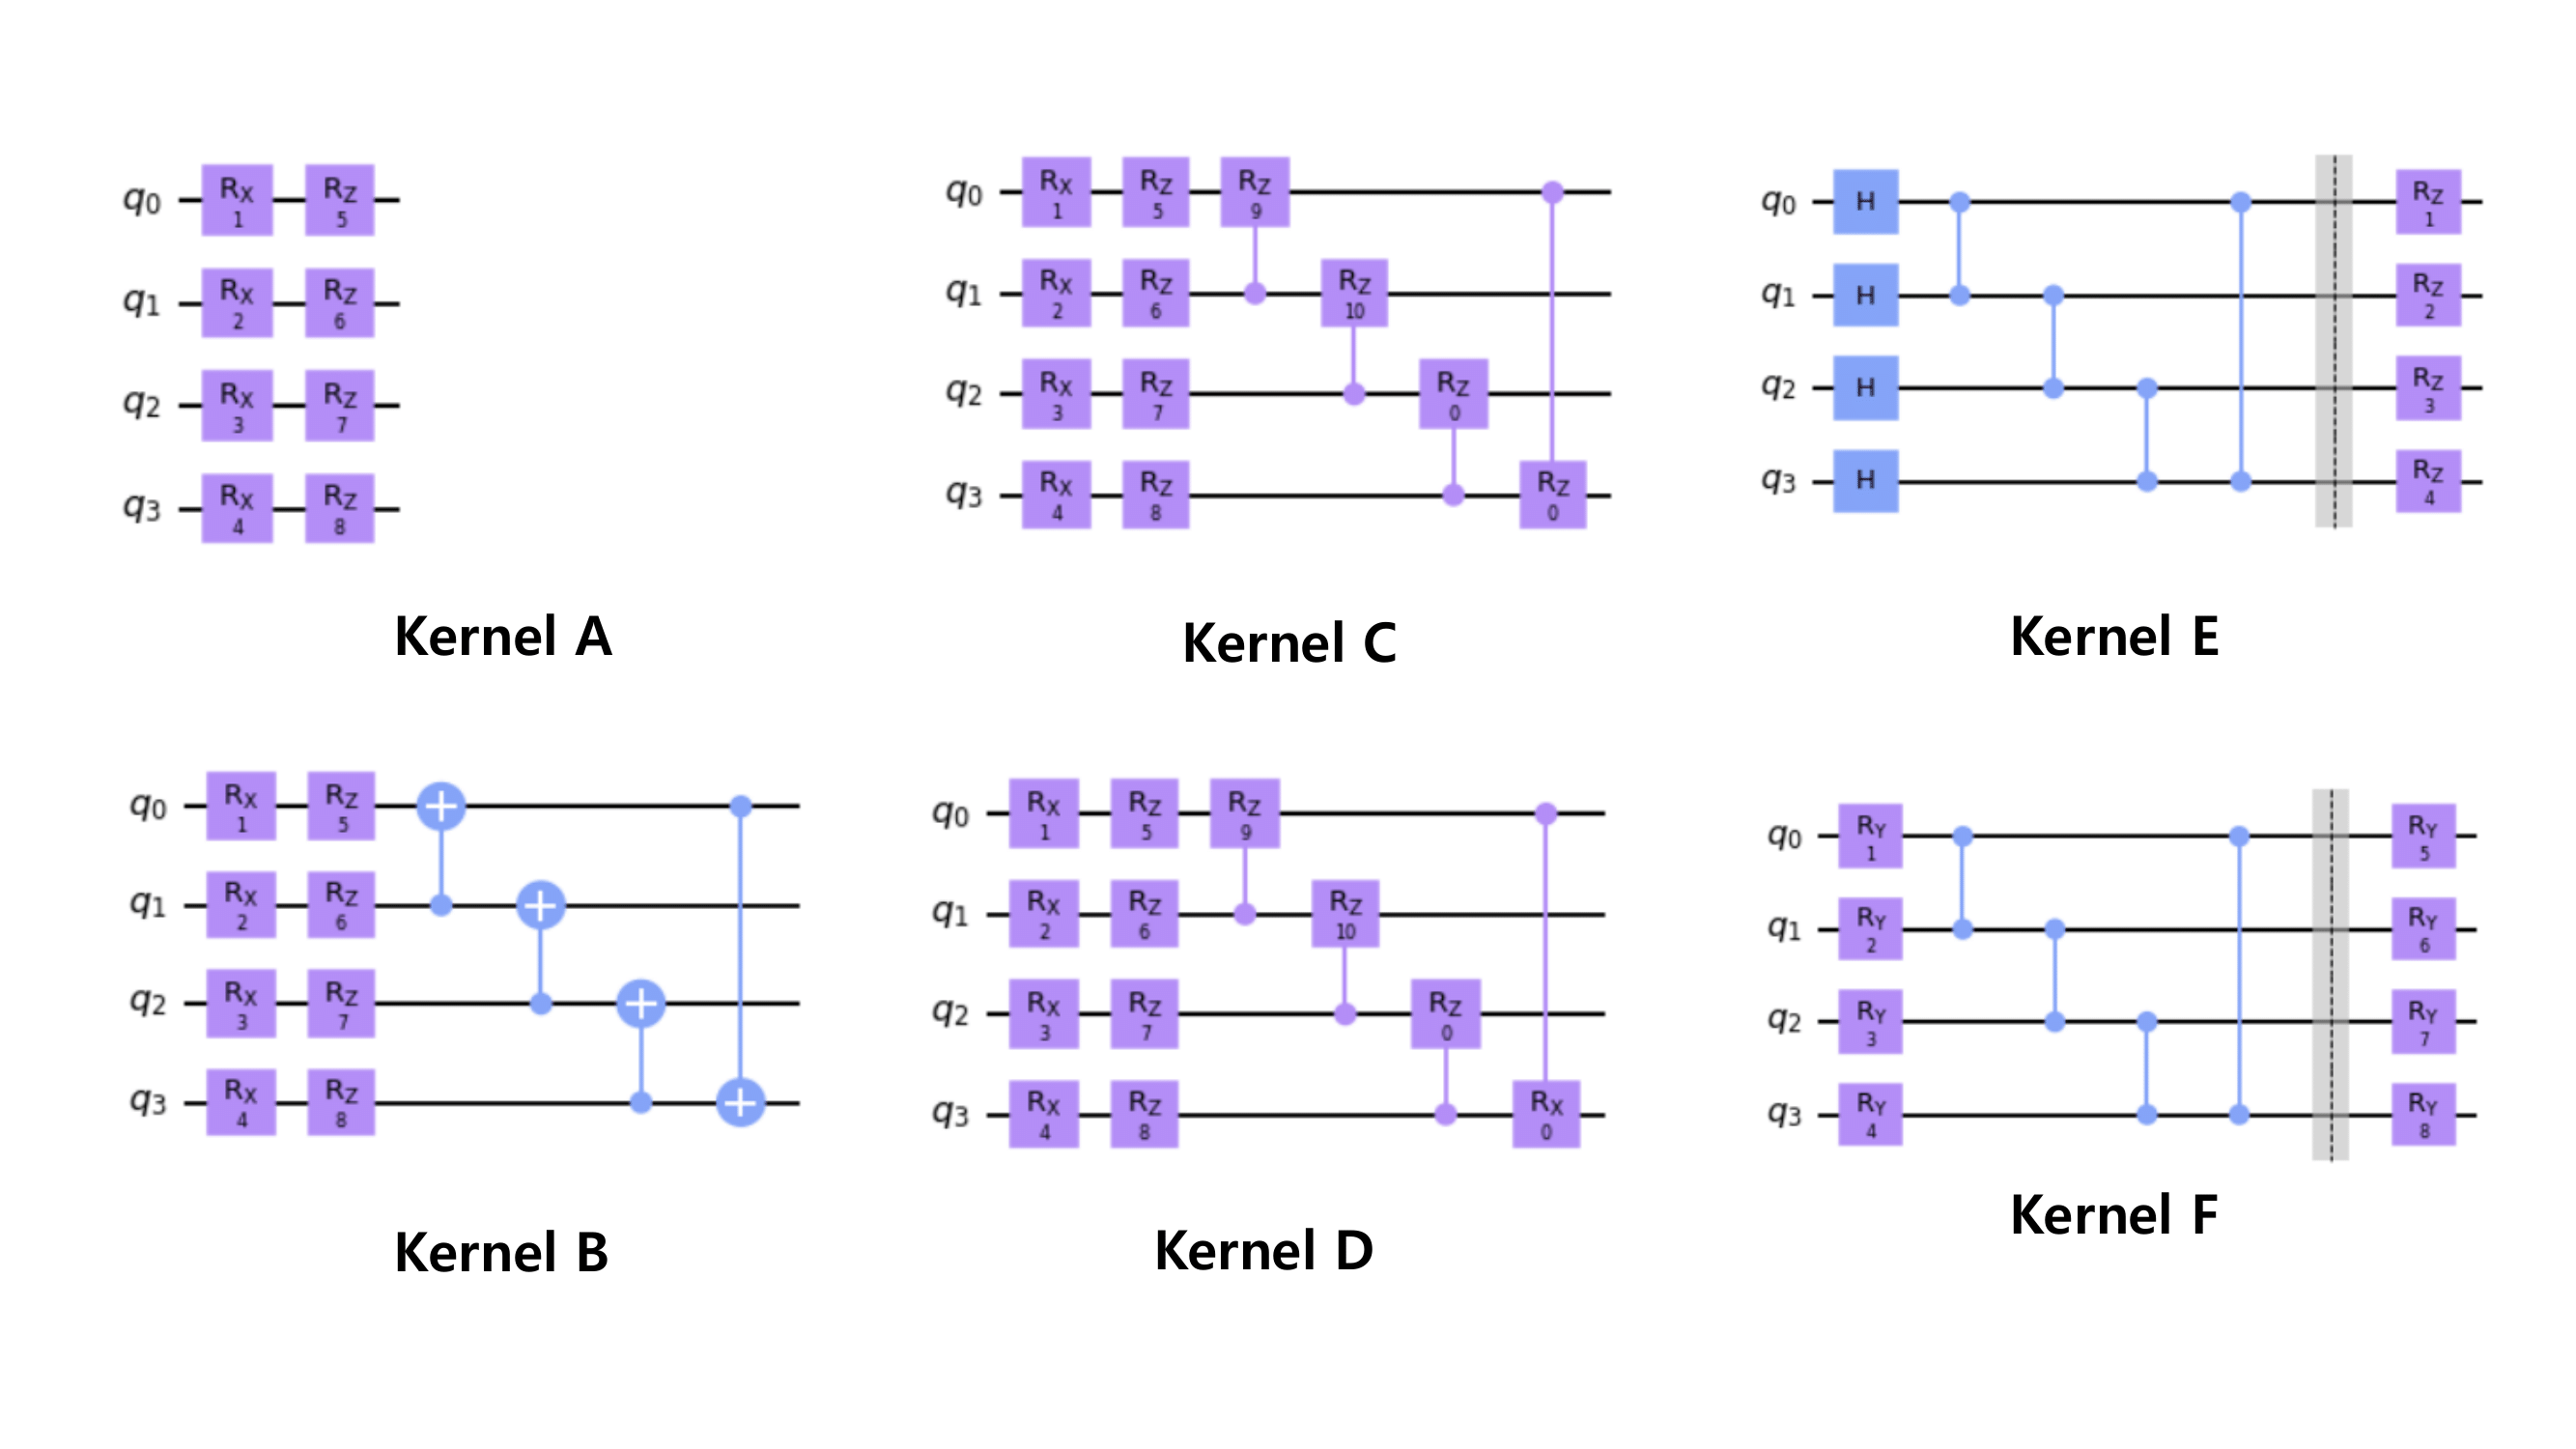

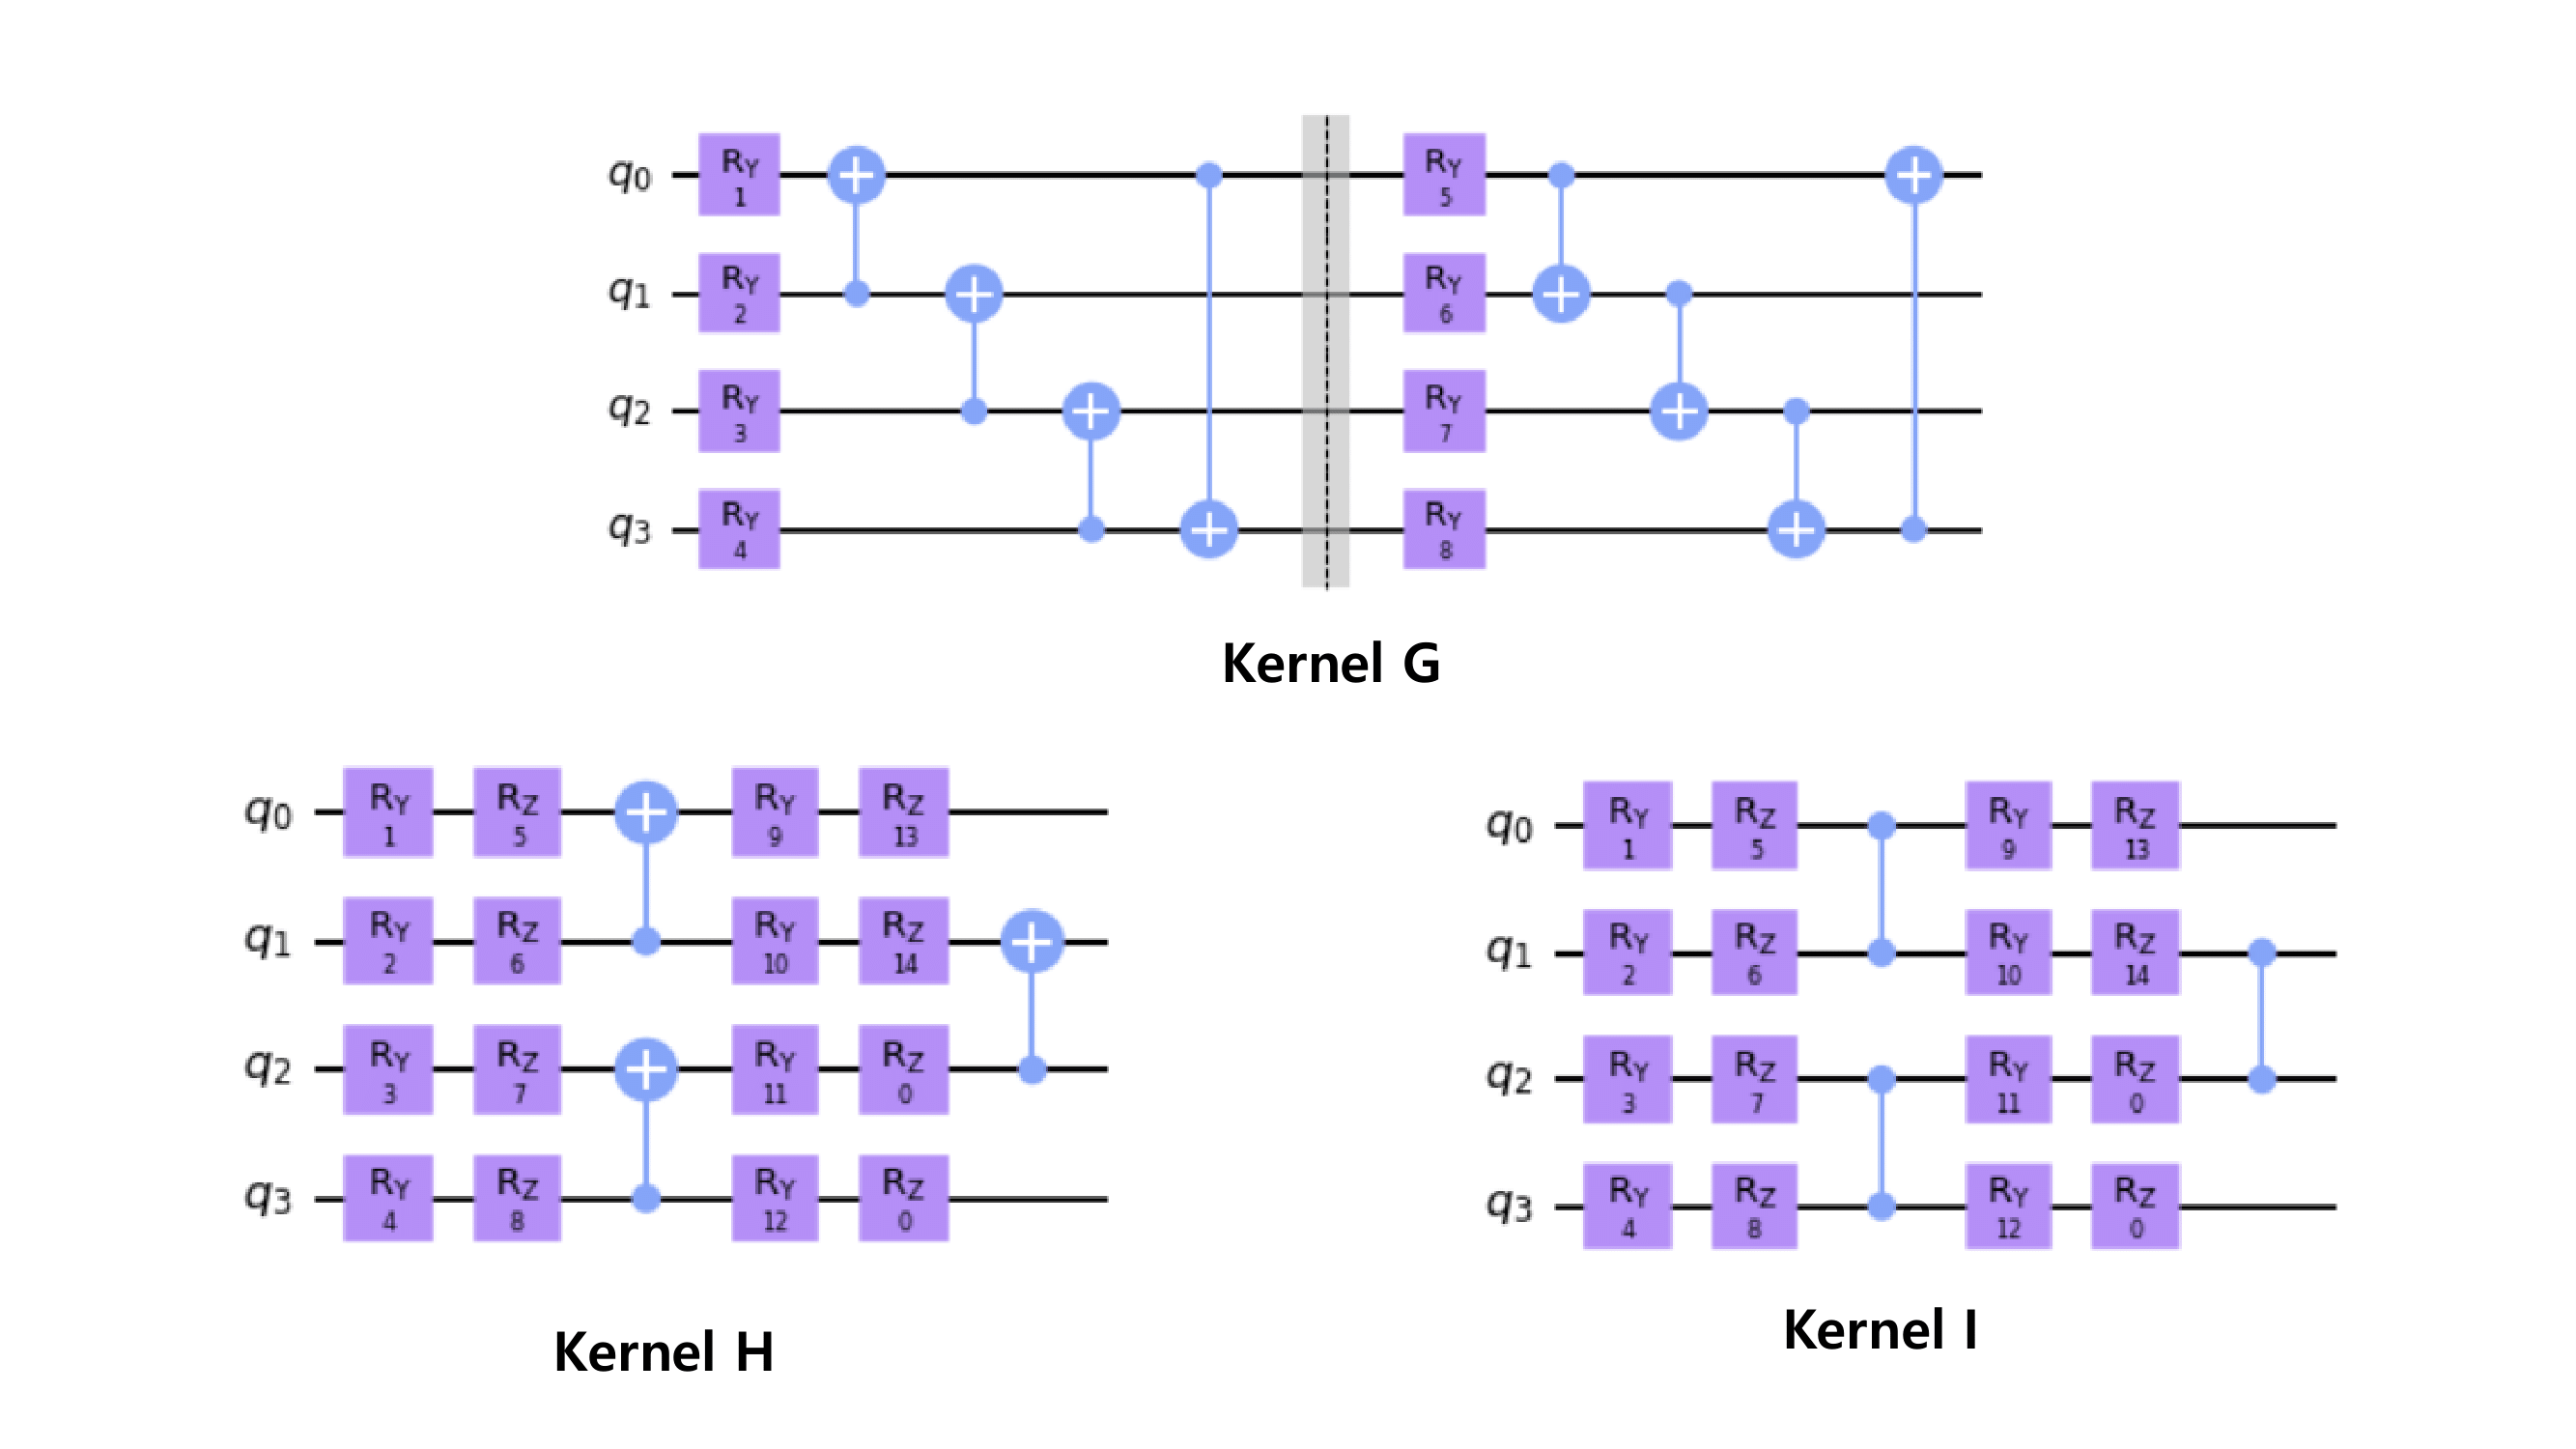

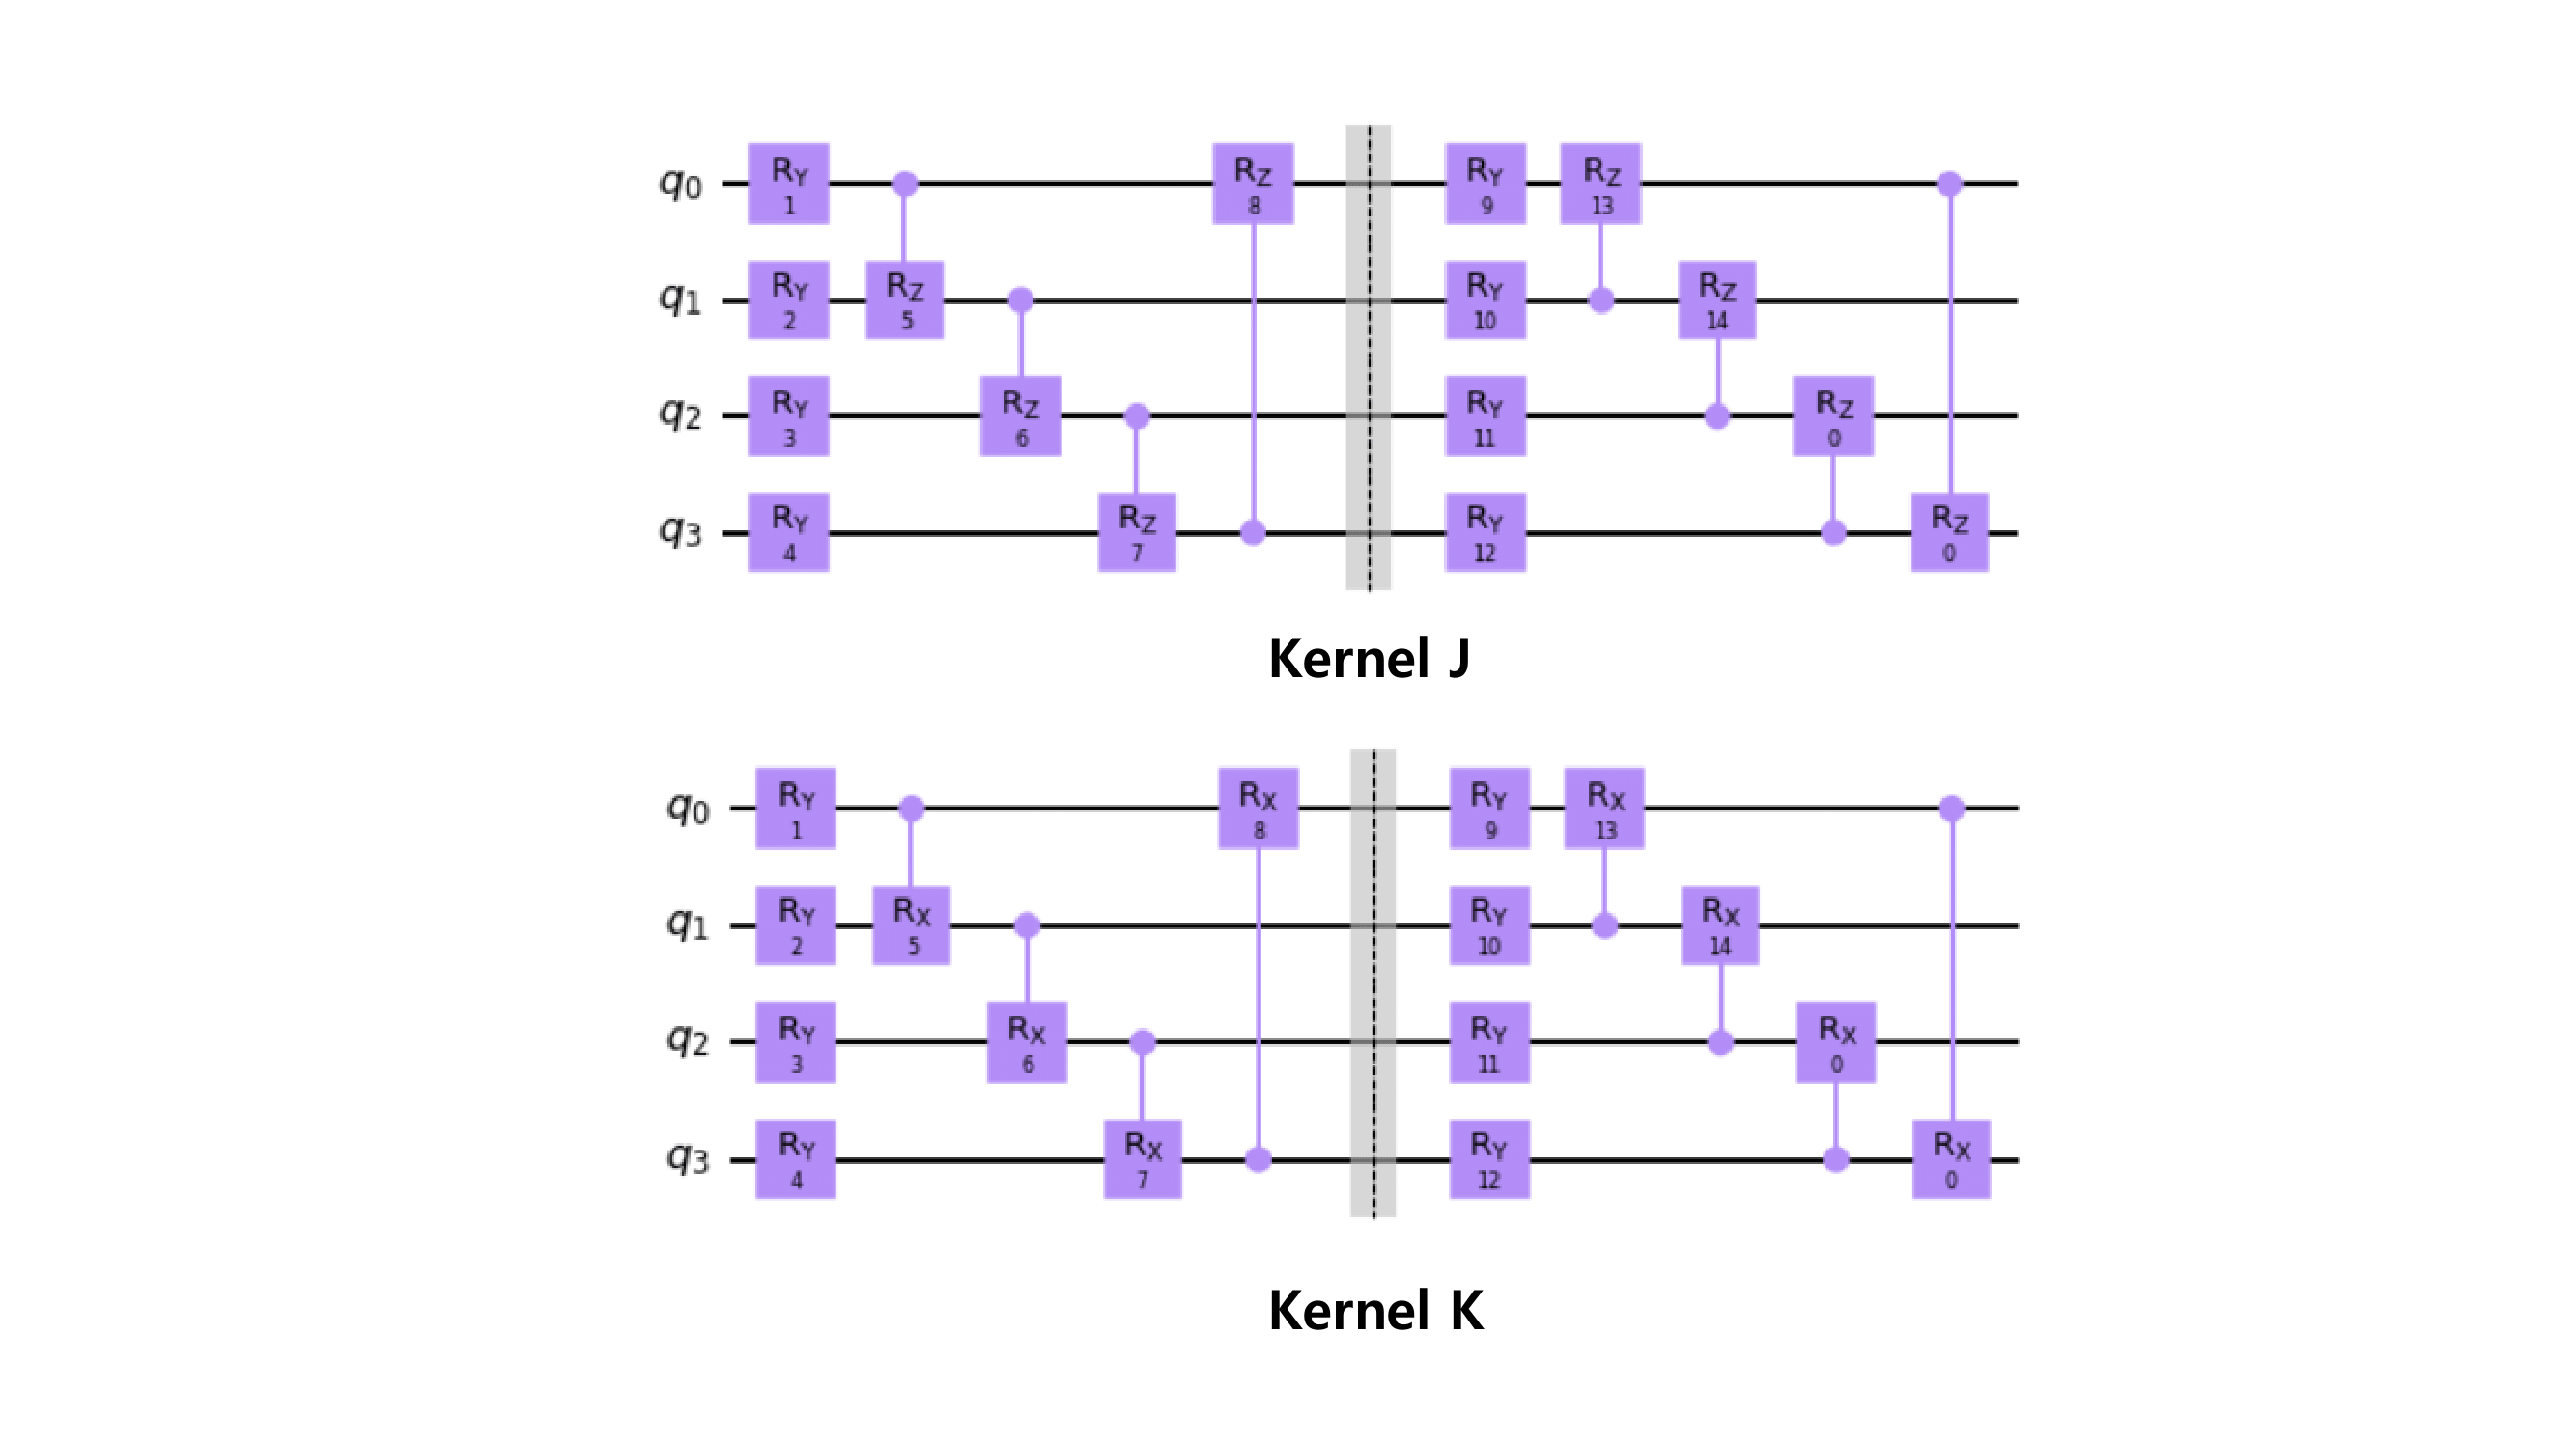

In [19]:
def swap_test(x_1,x_2,kernel):
    
    First_kernel = kernel(x_1)
    Second_kernel = kernel(x_2)
    n_kernel = First_kernel[1]
    
    qc = QuantumCircuit(n_kernel*2+1,1)
    qc.h(n_kernel*2)

    qc.append(First_kernel[0],range(n_kernel))
    qc.append(Second_kernel[0],range(n_kernel,(n_kernel*2)))

    for i in range(n_kernel):
        qc.cswap(n_kernel*2,i,i+n_kernel)
    qc.h(n_kernel*2)
    qc.measure(n_kernel*2,0)
    return(qc)

In [20]:
def hadamard_test(x_1,x_2,kernel):
    First_kernel = kernel(x_1)
    Second_kernel = kernel(x_2)
    n_kernel = First_kernel[1]
    
    qc = QuantumCircuit(n_kernel+1,1)
    qc.h(n_kernel)

    x_1 = First_kernel[0].control(1)
    x_2 = Second_kernel[0].control(1)
    qc.append(x_1,[n_kernel,*[i for i in range(n_kernel)]])
    qc.x(n_kernel)
    qc.append(x_2,[n_kernel,*[i for i in range(n_kernel)]])
    qc.h(n_kernel)
    qc.measure(n_kernel,0)
    return(qc)

In [21]:
def quantum_inner(method,x1,x2,kernel,shots=10000):
    if method == "hadamard" : test = hadamard_test
    elif method == "swap" : test = swap_test
    else : raise NameError('Wrong method name')
    
    circuit = test(x1,x2,kernel)
    
    backend = QasmSimulator()
    qc_compiled = transpile(circuit, backend)
    
    job = backend.run(qc_compiled, shots=shots)
    counts = job.result().get_counts ()
    
    hatpr0 = counts["0"]/shots
    if method == "hadamard" : quantum_inner = 2*hatpr0-1
    elif method == "swap" : quantum_inner = np.sqrt(2*hatpr0-1)
    return(quantum_inner)

In [22]:
x_1 = [1,2,3,4,5,6,7,8,9,10,11,12,13]
x_2 = [2,3,4,5,6,7,8,9,10,11,12,13,14]

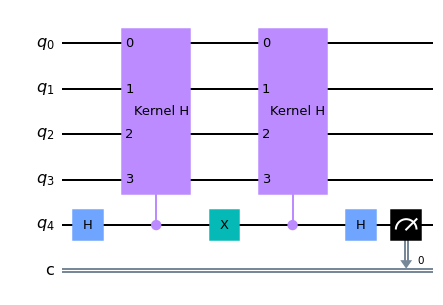

In [23]:
hadamard_test(x_1,x_2,kernel_H).draw("mpl")

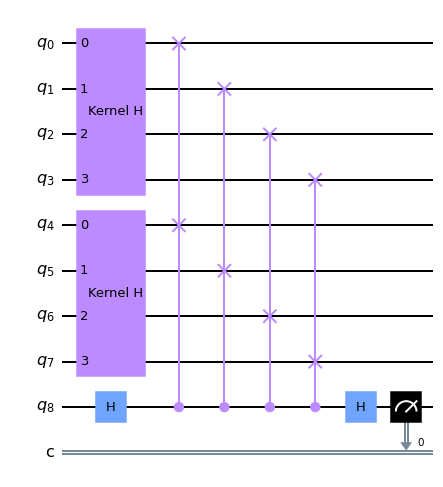

In [24]:
swap_test(x_1,x_2,kernel_H).draw("mpl")

In [25]:
quantum_inner("hadamard",x_1,x_2,kernel_A)

0.30479999999999996

In [26]:
quantum_inner("swap",x_1,x_2,kernel_A)

0.33105890714493685

In [27]:
def kernel_test(x):
    qc = QuantumCircuit(1,name = "Kernel test")
    qc.rx(x[0],0)
    encode = qc.to_gate()
    return [encode,1]

In [31]:
theta1 = [2.3]
theta2 = [0.7]

quantum_inner("hadamard",theta1,theta2,kernel_test,shots=10000)

0.6952